<!--HEADER-->
*Notas de aula de Modelagem Matemática - 2021/1 [- Ricardo M. S. Rosa (IM/UFRJ)](http://www.im.ufrj.br/rrosa)*

<!--BADGES-->
<a href="https://nbviewer.jupyter.org/github/rmsrosa/modelagem_matematica/blob/modmat2021p1/notas_de_aula/26.00-EDP_calor_bidimensional.ipynb" target="_blank"><img align="left" src="https://img.shields.io/badge/view%20in-nbviewer-orange" alt="View in NBViewer" title="View in NBViewer"></a><a href="https://mybinder.org/v2/gh/rmsrosa/modelagem_matematica/julia-env-for-binder-2021p1?urlpath=git-pull%3Frepo%3Dhttps%253A%252F%252Fgithub.com%252Frmsrosa%252Fmodelagem_matematica%26branch%3Dmodmat2021p1%26urlpath%3Dtree%252Fmodelagem_matematica%252Fnotas_de_aula/26.00-EDP_calor_bidimensional.ipynb" target="_blank"><img align="left" src="https://mybinder.org/badge.svg" alt="Open in binder" title="Open in binder"></a><a href="https://nbviewer.jupyter.org/github/rmsrosa/modelagem_matematica/blob/modmat2021p1/notas_de_aula/slides/26.00-EDP_calor_bidimensional.slides.html" target="_blank"><img align="left" src="https://img.shields.io/badge/view-slides-darkgreen" alt="View Slides" title="View Slides"></a>&nbsp;

<!--NAVIGATOR-->
[<- 25. Equação da onda unidimensional](25.00-EDP_onda.ipynb) | [Página inicial](00.00-Pagina_inicial.ipynb) | [27. Equação da onda em duas dimensões espaciais ->](27.00-EDP_onda_bidimensional.ipynb)

---


# Equação do calor em duas dimensões espaciais

In [1]:
using DifferentialEquations
using Plots

## Aproximação em diferenças finitas do laplaciano

* Vamos considerar o caso de condições de contorno homogêneas do tipo Dirichlet, i.e. $u|_{\partial\Omega} = 0$.

* Usaremos uma malha $\{(x_i,y_j)\}_{i,j}$ de pontos em um domínio $\Omega = (0,L_x)\times(0,L_y)$.

* No interior, vamos aproximar
$$ \begin{multline*}
  \Delta u(x,y) = u_{xx}(x,y) + u_{yy}(x,y) \\ \approx \frac{u(x+h_x,y) - 2u(x,y) + u(x-h_x,y)}{h_x^2} + \frac{u(x, y+h_y) - 2u(x,y) + u(x,y-h_y)}{h_y^2}.
  \end{multline*}
$$

* Julia, assim como o Fortran, guarda *arrays* na memória em formato *column-major*, o que significa que eles são guardados coluna a coluna, ou seja, a primeira coluna inteira, de forma contígua, seguida da segunda coluna, e assim por diante. 

* Nesse sentido, é diferente do Python, que guarda cada linha de maneira contígua, chamada *row-major*.

* Por esse motivo, é mais rápido fazer o *loop* duplo com o *loop* interior percorrendo as linhas e o *loop* exterior, as colunas.

In [2]:
function δ²(u::Matrix{Float64}, hx2::Float64, hy2::Float64, ::Val{:dir})
    n, m = size(u)
    ddu = zero(u)
    for j = 2:m-1
        for i = 2:n-1
            ddu[i,j] = (u[i,j+1] - 2u[i,j] + u[i,j-1])/hx2 + 
                (u[i+1,j] - 2u[i,j] + u[i-1,j])/hy2
        end
    end
    return ddu
end

δ² (generic function with 1 method)

In [3]:
function dudt_calor2d!(dudt::Matrix{Float64}, u::Matrix{Float64}, p::Vector{Float64}, t::Float64)
    κ, hx2, hy2 = p
    du = δ²(u, hx2, hy2, Val(:dir))
    dudt .= κ * du
    return nothing
end

dudt_calor2d! (generic function with 1 method)

In [4]:
κ = 0.01 # coeficiente de difusão térmica
Lx = 2π # comprimento na direção x do domínio [0,Lx]×[0,Ly]
Ly = π # comprimento na direção y do domínio [0,Lx]×[0,Ly]
Nx = 60 # número de pontos da malha na direção x
Ny = 40 # número de pontos da malha na direção x
hx = Lx/(Nx-1) # comprimento de cada partição da malha em x
hy = Ly/(Ny-1) # comprimento de cada partição da malha em y
x = range(0.0, Lx, length=Nx) # discretização espacial na direção x
y = range(0.0, Ly, length=Ny) # discretização espacial na direção y
σ = 0.5
u₀ = exp.(-(y .- Ly/2).^2/2/σ^2) * exp.(-(x .- Lx/2).^2/2/σ^2)' # condição inicial
u₀[1,:] .= u₀[end,:] .= 0 # zero nos bordos laterais
u₀[:,1] .= u₀[:,end] .= 0 # zero nos bordos inferior e superior
p = [κ, hx^2, hy^2] # parâmetros
Tf = 12 # tempo final
τ = 0.1 # intervalos de tempo
tspan = (0.0,Tf) # intervalo de tempo
prob = ODEProblem(dudt_calor2d!, u₀, tspan, p, saveat = τ)
nothing

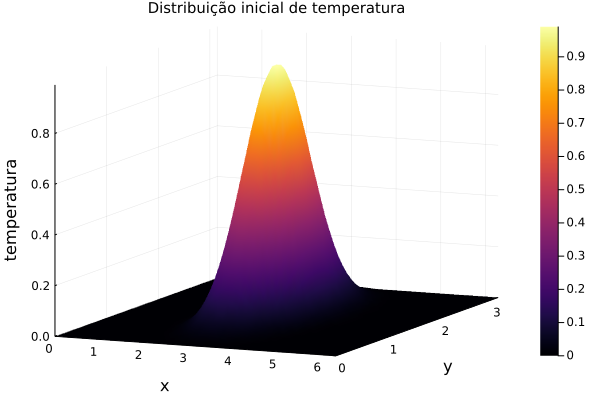

In [5]:
surface(x, y, u₀, xlabel="x", ylabel="y", zlabel="temperatura", 
    title="Distribuição inicial de temperatura", titlefont=10)

In [6]:
sol = solve(prob, Tsit5())
sol.retcode

:Success

┌ Info: Saved animation to 
│   fn = /Users/rrosa/Documents/git_repositories/modelagem_matematica/notas_de_aula/img/anim_calor2D_a.gif
└ @ Plots /Users/rrosa/.julia/packages/Plots/SVksJ/src/animation.jl:104


Plots.AnimatedGif("/Users/rrosa/Documents/git_repositories/modelagem_matematica/notas_de_aula/img/anim_calor2D_a.gif")
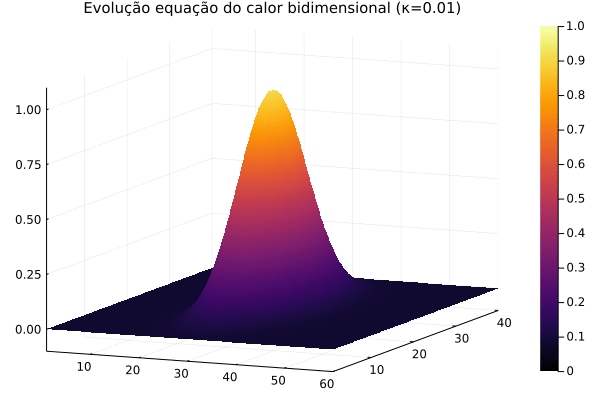

In [7]:
anim = @animate for (t,u) in zip(sol.t, sol.u)
    surface(u, zlims=(-0.1, 1.1), label="t=$(round(t,digits=2))", clims=(0.0, 1.0),
        title="Evolução equação do calor bidimensional (κ=$κ)", titlefont=10)
end
gif(anim, joinpath("img", "anim_calor2D_a.gif"), fps = 20)

┌ Info: Saved animation to 
│   fn = /Users/rrosa/Documents/git_repositories/modelagem_matematica/notas_de_aula/img/anim_calor2D_b.gif
└ @ Plots /Users/rrosa/.julia/packages/Plots/SVksJ/src/animation.jl:104


Plots.AnimatedGif("/Users/rrosa/Documents/git_repositories/modelagem_matematica/notas_de_aula/img/anim_calor2D_b.gif")
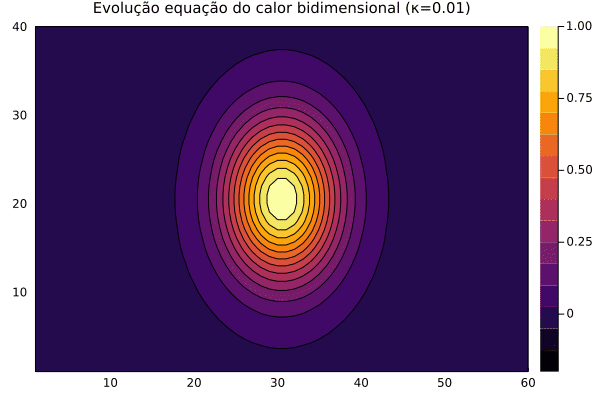

In [8]:
anim = @animate for (t,u) in zip(sol.t, sol.u)
    contourf(u, label="t=$(round(t,digits=2))", clims=(-0.2, 1.0),
        title="Evolução equação do calor bidimensional (κ=$κ)", titlefont=10)
end
gif(anim, joinpath("img", "anim_calor2D_b.gif"), fps = 20)

┌ Info: Saved animation to 
│   fn = /Users/rrosa/Documents/git_repositories/modelagem_matematica/notas_de_aula/img/anim_calor2D_c.gif
└ @ Plots /Users/rrosa/.julia/packages/Plots/SVksJ/src/animation.jl:104


Plots.AnimatedGif("/Users/rrosa/Documents/git_repositories/modelagem_matematica/notas_de_aula/img/anim_calor2D_c.gif")
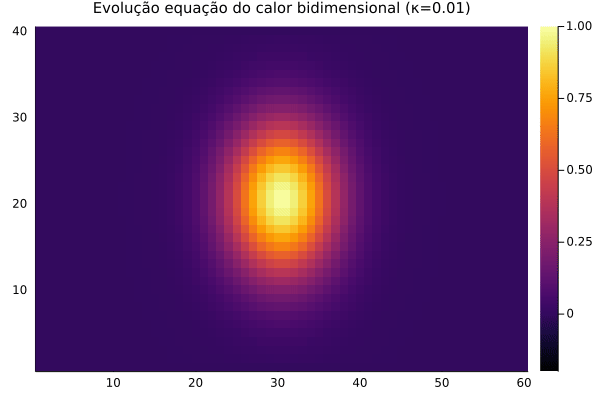

In [9]:
anim = @animate for (t,u) in zip(sol.t, sol.u)
    heatmap(u, label="t=$(round(t,digits=2))", clims=(-0.2, 1.0),
        title="Evolução equação do calor bidimensional (κ=$κ)", titlefont=10)
end
gif(anim, joinpath("img", "anim_calor2D_c.gif"), fps = 20)

<!--NAVIGATOR-->

---
[<- 25. Equação da onda unidimensional](25.00-EDP_onda.ipynb) | [Página inicial](00.00-Pagina_inicial.ipynb) | [27. Equação da onda em duas dimensões espaciais ->](27.00-EDP_onda_bidimensional.ipynb)